In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input, GlobalMaxPooling1D
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder

## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_4.csv')


In [ ]:
dataset.shape

(1210, 2)

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train[:10])

1160    rest spiritual furniture modest scattered tend...
557     meantime widow cranfield went bustling house f...
1181    offered hand took grasp became would seen fine...
1084    long reached spot rather tall house uninhabite...
253     seeing grown one fairest maidens many valorous...
802     call multiplied cares housekeeping without sub...
1119    use try follow farther to-night thought youth ...
34      period landing clive young writer india close ...
320     rudge could leave wife daughters without retur...
790     could come nothing kindly terms went engaged d...
Name: processed_text, dtype: object


## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
print(y_valid)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


# TextVectorization

## Model 1

In [ ]:
embedding_dim = 512
vocab_size = 90000
sequence_length = 9000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 9000, 512)         46080000  
                                                                 
 conv1d (Conv1D)             (None, 8997, 512)         1049088   
                                                                 
 max_pooling1d (MaxPooling1  (None, 4498, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d (  (None, 512)               0     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 32, callbacks=[model_checkpoint_callback])

Epoch 1/10
28/28 [==============================] - 36s 709ms/step - loss: 2.8431 - accuracy: 0.1045 - val_loss: 2.8012 - val_accuracy: 0.1134
Epoch 2/10
28/28 [==============================] - 17s 610ms/step - loss: 2.5296 - accuracy: 0.1665 - val_loss: 2.4913 - val_accuracy: 0.3299
Epoch 3/10
28/28 [==============================] - 17s 606ms/step - loss: 2.1862 - accuracy: 0.3157 - val_loss: 2.2269 - val_accuracy: 0.2577
Epoch 4/10
28/28 [==============================] - 18s 630ms/step - loss: 1.6531 - accuracy: 0.4799 - val_loss: 1.6886 - val_accuracy: 0.4021
Epoch 5/10
28/28 [==============================] - 18s 642ms/step - loss: 1.1375 - accuracy: 0.6625 - val_loss: 1.2133 - val_accuracy: 0.6186
Epoch 6/10
28/28 [==============================] - 18s 632ms/step - loss: 0.7258 - accuracy: 0.8117 - val_loss: 0.9000 - val_accuracy: 0.6907
Epoch 7/10
28/28 [==============================] - 17s 623ms/step - loss: 0.4974 - accuracy: 0.8714 - val_loss: 0.7322 - val_accuracy: 0.7320

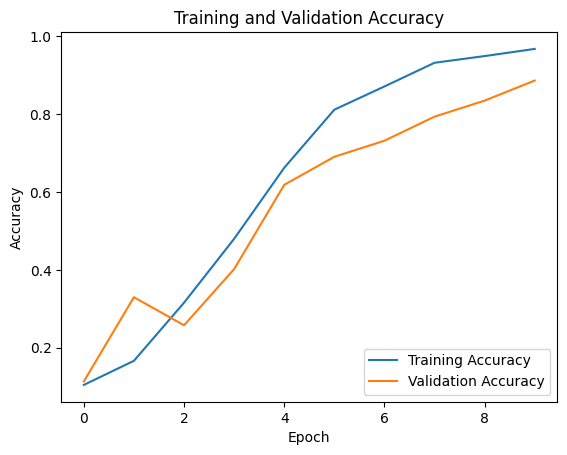

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 2s 194ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.9214876033057852
F1 Score: 0.9208104245935105
Precision: 0.9288406955762327
Recall: 0.9214876033057852


## Model 2

In [ ]:
embedding_dim = 512
vocab_size = 90000
sequence_length = 9000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(256, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 9000, 512)         46080000  
                                                                 
 conv1d (Conv1D)             (None, 8997, 512)         1049088   
                                                                 
 max_pooling1d (MaxPooling1  (None, 4498, 512)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 4495, 256)         524544

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
109/109 [==============================] - 35s 234ms/step - loss: 2.7682 - accuracy: 0.1033 - val_loss: 2.5899 - val_accuracy: 0.1753
Epoch 2/10
109/109 [==============================] - 22s 203ms/step - loss: 2.2974 - accuracy: 0.1848 - val_loss: 2.2104 - val_accuracy: 0.2371
Epoch 3/10
109/109 [==============================] - 23s 207ms/step - loss: 1.8839 - accuracy: 0.3341 - val_loss: 1.9421 - val_accuracy: 0.3299
Epoch 4/10
109/109 [==============================] - 23s 213ms/step - loss: 1.5015 - accuracy: 0.4145 - val_loss: 1.8964 - val_accuracy: 0.3093
Epoch 5/10
109/109 [==============================] - 24s 219ms/step - loss: 1.2339 - accuracy: 0.5431 - val_loss: 1.6244 - val_accuracy: 0.4124
Epoch 6/10
109/109 [==============================] - 22s 200ms/step - loss: 0.8948 - accuracy: 0.6602 - val_loss: 1.6355 - val_accuracy: 0.4227
Epoch 7/10
109/109 [==============================] - 23s 210ms/step - loss: 0.8827 - accuracy: 0.7003 - val_loss: 1.4201 - val_ac

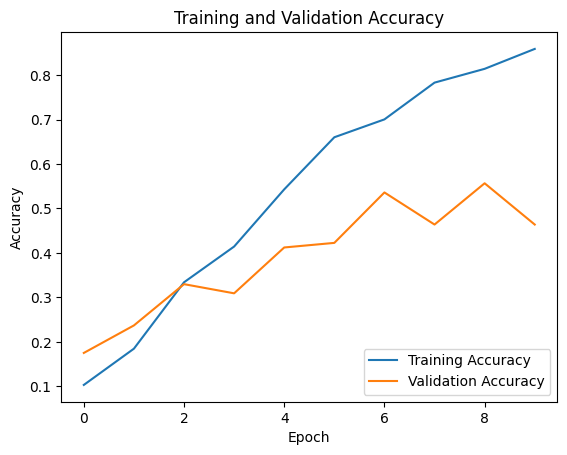

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 2s 234ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.5661157024793388
F1 Score: 0.562727758605742
Precision: 0.6452749874454963
Recall: 0.5661157024793388
